Song Recommendation 

In [1]:
import pandas as pd
import numpy.linalg as la
import numpy as np
import os
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=3)

In [2]:
def create_matrix(path, n):
    with open(path) as infile:
        count = 0;
        list = []
        
        for line in infile:
            temp_list=[]
            count = count+1
            temp_list = line.split()
            list.append(temp_list)
            if count==n:
                break
        
    return list
    

def preprocess(matrix):
    matrix = pd.DataFrame(matrix)
    #matrix = matrix.T
    cols = ['listeners','songs','occurences']
    matrix.columns = cols
    while 1 : 
        min_listeners = matrix.groupby('listeners').count().min()[0]
        min_songs = matrix.groupby('songs').count().min()[0]
        matrix = matrix.groupby('listeners').filter(lambda x: len(x) > 5)
        matrix = matrix.groupby('songs').filter(lambda x: len(x) > 5)
        if min_listeners>5 and min_songs>5:
            break;
    return matrix


def create_dictionary(list):
    dict_1 = {}
    dict_2 = {}
    count = 0;
    for element in list:
        if not element in dict_1:
            dict_1[element] = count
            dict_2[count] = element
            count = count+1
    return dict_1,dict_2
            
    
def count_to_bin(a,b):
    bin = 0
    for x in range (b):
        if a>=2**x and a<=((2**(x+1))-1):
            return x+1
    return b

def phase1(path, n):
    matrix = create_matrix(path, n)
    matrix = preprocess(matrix)
    matrix = np.asarray(matrix) #turn it back to ndarray
    matrix[:,2] = list(map(int, matrix[:,2])) #parses the string counts to integer
    return matrix


def phase2(in_matrix):
    matrix = in_matrix.copy()
    users = matrix[:,0] #first column represents the users
    songs = matrix[:,1] #second column represents the songs
    users_dict1 , users_dict2 = create_dictionary(users) #gives incremental integer values to all users
    songs_dict1 , songs_dict2 = create_dictionary(songs) #gives incremental integer values to all songs

    matrix[:,2] = [count_to_bin(x , 7) for x in matrix[:,2]] #bin representation of the counts
    matrix[:,1] = [songs_dict1[x] for x in matrix[:,1]] #incremental represantation of the songs
    matrix[:,0] = [users_dict1[x] for x in matrix[:,0]] #incremental represantation of the listeners
    return matrix, users_dict1, users_dict2, songs_dict1, songs_dict2


In [3]:
def evaluate_RMSE(test, P, Q):
    y_hat = np.zeros([test.shape[0],1])
    y = test[:,2]
    c = 0
    for row in test:
        y_hat[c] = P[row[0],:].dot(Q[row[1],:].T)
        c +=1
    return RMSE(y_hat, y)


def RMSE(y_hat, y): # y_hat --> observed, y --> prediction, they both are col vectors    
    return np.sqrt(np.mean((y - y_hat)**2)) 


def R_to_M(n, m, R):
    N = R.shape[0]
    M = np.zeros([n,m])
    for i in range(N):
        row = R[i,0]
        col = R[i,1]
        M[row,col] = R[i,2]
    return M


def initialize_PQ(n,m,k):
    np.random.seed(100)
    return np.random.rand(n,k), np.random.rand(m,k)


def initialize_PQ_svd(n, m, R, k, given="R"):
    M = R if(given == "M") else R_to_M(n, m, R)
    U,S,V = la.svd(M)
    S_sq = np.sqrt(S)
    return U[:,:k].dot(np.diag(S_sq[:k])), np.diag(S_sq[:k]).dot(V[:k,:]).T
    

def alternating_lstsq(R, p2q, q2p, P, Q, k, cycles):
    n = P.shape[0]
    m = Q.shape[0]
    
    err = list()
    err.append(evaluate_RMSE(R, P, Q))    
    iteration = 0
    while True:     
        iteration += 1
        print(iteration)
        for i in range(n): # use/find fixed Q(items) and solve for p_i(user)        
            if i in p2q:                
                Ai, b = p2q[i]            
                A = Q[Ai,:]
                P[i, :] = la.lstsq(A,b)[0].reshape(k)

        for i in range(m): # use/find fixed P(users) and solve for q_i(song)        
            if i in q2p:                
                Ai, b = q2p[i]            
                A = P[Ai,:]
                Q[i, :] = la.lstsq(A,b)[0].reshape(k)
        
        err.append(evaluate_RMSE(R, P, Q))
        if(iteration == cycles): break            
    return P, Q, err
    
    
def important_fn(R):
    p_to_q = dict()    
    q_to_p = dict()
    for row in R:
        if row[0] in p_to_q:
            tup = p_to_q[row[0]]
            tup[0].append(row[1])
            tup[1].append(row[2])
        else:
            p_to_q[row[0]] = [[row[1]], [row[2]]]
            
        if row[1] in q_to_p:
            tup = q_to_p[row[1]]
            tup[0].append(row[0])
            tup[1].append(row[2])
        else:
            q_to_p[row[1]] = [[row[0]], [row[2]]]                    
    return p_to_q, q_to_p

In [4]:
path = "../../../../../Downloads/train_triplets.txt"
matrix1 = phase1(path, 20000)

In [5]:
pd.DataFrame(matrix1, columns=["User ID", "Song ID", "Play count"]).head(10)

,User ID,Song ID,Play count
0,e006b1a48f466bf59feefed32bec6494495a4436,SOAUWYT12A81C206F1,2
1,e006b1a48f466bf59feefed32bec6494495a4436,SOAXGDH12A8C13F8A1,2
2,e006b1a48f466bf59feefed32bec6494495a4436,SOBONKR12A58A7A7E0,2
3,e006b1a48f466bf59feefed32bec6494495a4436,SODJWHY12A8C142CCE,1
4,e006b1a48f466bf59feefed32bec6494495a4436,SOEGIYH12A6D4FC0E3,3
5,e006b1a48f466bf59feefed32bec6494495a4436,SOFRQTD12A81C233C0,3
6,e006b1a48f466bf59feefed32bec6494495a4436,SOLFXKT12AB017E3E0,2
7,e006b1a48f466bf59feefed32bec6494495a4436,SONYKOW12AB01849C9,2
8,e006b1a48f466bf59feefed32bec6494495a4436,SOSXLTC12AF72A7F54,2
9,e006b1a48f466bf59feefed32bec6494495a4436,SOTWNDJ12A8C143984,1


In [6]:
matrix2, u_dict1, u_dict2, s_dict1, s_dict2 = phase2(matrix1)
pd.DataFrame(matrix2, columns=["User Index", "Song Index", "Bin#"]).head(20)

,User Index,Song Index,Bin#
0,0,0,2
1,0,1,2
2,0,2,2
3,0,3,1
4,0,4,2
5,0,5,2
6,0,6,2
7,0,7,2
8,0,8,2
9,0,9,1


In [15]:
#if init == "svd" else initialize_PQ_svd(n, m, R, k) 
n = matrix2[:,0].max()+1  # num of users
m = matrix2[:,1].max()+1  # num of movies

cycles = 100  # repetition of als
k = 30 # number of latent factors
p2q, q2p = important_fn(matrix2)
P, Q = initialize_PQ(n, m, k)


P, Q, err = alternating_lstsq(matrix2, p2q, q2p, P, Q, k, cycles)


#M = R_to_M(n,m,data)
#print("P")
#print(P)
#print("\nQ")
#print(Q)
#print("\nP * Q.T")
#print(P.dot(Q.T))
#print("\nM")
#print(M)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


[5.7959931680596881, 1.5292150782729086, 1.5292272745557576, 1.529210485097527, 1.5292080274573507, 1.5292076554305132, 1.5292076005681832, 1.5292075890309267, 1.5292075860641416, 1.5292075855335738, 1.5292075854494511, 1.5292075854335074, 1.52920758543029, 1.5292075854296108, 1.5292075854295046, 1.5292075854294906, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.5292075854294909, 1.

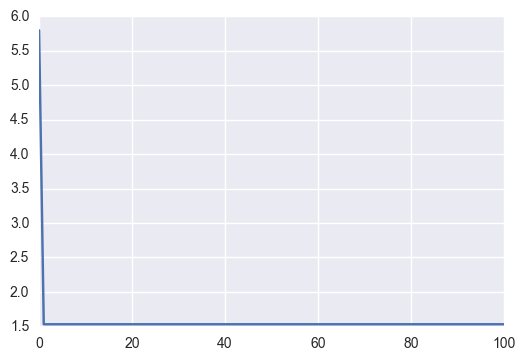

In [16]:
print(err)
%matplotlib inline
plt.plot(err)